# Emotion Recognition with simple CNN

### Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

2025-12-21 11:10:06.434253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices("GPU"))

# Check if TensorFlow is using GPU
print("TensorFlow GPU:", tf.test.is_built_with_cuda())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU: True


### Dataset loading

In [2]:
# Load dataset
from keras.preprocessing import image_dataset_from_directory

cwd: str = os.getcwd()

train_dir: str = os.path.join(cwd, "../data/train")
test_dir: str = os.path.join(cwd, "../data/test")

batch_size: int = 128
img_size: tuple = (48, 48)
seed: int = 42

class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Load training and validation datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1766308217.429870    1110 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:06:00.0, compute capability: 8.9


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


Show one example image for each class from the training dataset

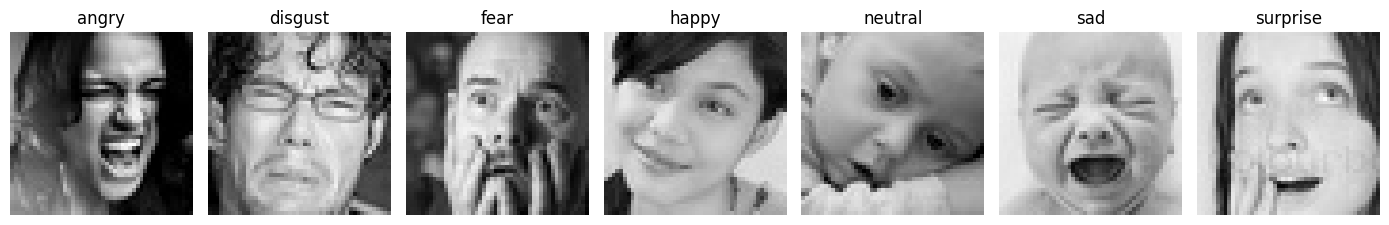

In [3]:
num_classes: int = len(class_names)

examples = [None] * num_classes

for img_tensor, cls in train_dataset.unbatch():
    idx = int(cls.numpy())  # label is already an int
    if examples[idx] is None:
        examples[idx] = img_tensor.numpy()
    if all(e is not None for e in examples):
        break

fig, axes = plt.subplots(1, num_classes, figsize=(14, 3))
for ax, img_arr, cname in zip(axes, examples, class_names):
    ax.imshow(img_arr.astype("uint8"))
    ax.set_title(cname)
    ax.axis("off")

fig.tight_layout()
plt.show()

In [4]:
def plot_class_distribution(dataset_dir, subset_name):
    """Plot the class distribution of the dataset"""
    class_count = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        num_images = len(os.listdir(class_dir))
        class_count[class_name] = num_images

    plt.figure(figsize=(10, 5))
    plt.bar(class_count.keys(), class_count.values())
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Class distribution" + " " + subset_name)
    plt.show()

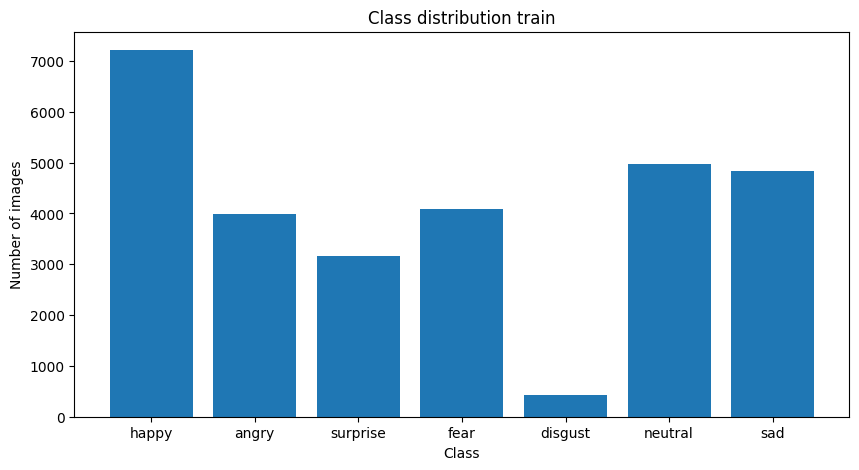

In [5]:
plot_class_distribution(train_dir, "train")

In [35]:
# Print class distribution
class_count = {}
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_count[class_name] = num_images

print("Class Distribution:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count}")

Class Distribution:
happy: 7215
angry: 3995
surprise: 3171
fear: 4097
disgust: 436
neutral: 4965
sad: 4830


### Helper Classes and Functions

In [19]:
class DatasetPreparer:
    def __init__(self):
        self.data_augmentation = self._create_augmentation_pipeline()

    def _create_augmentation_pipeline(self):
        """Create the data augmentation pipeline"""
        return keras.Sequential(
            [
                keras.layers.RandomFlip("horizontal"),
                keras.layers.RandomRotation(0.1),
            ]
        )

    def preprocess_image(self, image, to_gray):
        """Convert image to grayscale float32 and normalize"""
        if to_gray:
            image = tf.image.rgb_to_grayscale(image)

        # Normalize to [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32) / 255.0

        # Boost contrast
        image = tf.image.adjust_contrast(image, 2.0)
        return image

    def augment_and_preprocess(self, image, augment, to_gray):
        """Apply data augmentation and preprocess the image"""
        if augment:
            image = self.data_augmentation(image)
        return self.preprocess_image(image, to_gray)

    def prepare_dataset(self, dataset, augment=False, to_gray=False):
        """Prepare a single dataset split for training"""
        dataset = dataset.map(
            lambda x, y: (self.augment_and_preprocess(x, augment, to_gray), y),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset


In [5]:
def plot_history(history) -> None:
    """Function to plot the training and validation history"""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.show()


In [ ]:
def metrics(model, class_names, test_ds):
    """Function to calculate the metrics of the model"""
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Loss: {test_loss}")
    print(f"Accuracy: {test_accuracy}")
    print("\n")

    # Make predictions
    predictions = model.predict(test_ds)
    y_pred = np.argmax(predictions, axis=1)

    # Get the true labels
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    # Check if labels are one-hot or integer before applying argmax
    if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)

    # Print classification report
    from sklearn.metrics import classification_report

    print(classification_report(y_true, y_pred))

    # Generate confusion matrix
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [7]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Dict, Any, Union, List


def generate_class_weights(
    class_series: Union[List[Any], np.ndarray],
    multi_class: bool = True,
    one_hot_encoded: bool = False,
) -> Dict[int, float]:
    """
    Generates Keras-compatible class weights.

    - Multi-class: returns weights usable with `class_weight`
    - Multi-label: returns per-class weights (must be converted to sample_weight)
    """

    # -----------------------
    # MULTI-CLASS
    # -----------------------
    if multi_class:
        if one_hot_encoded:
            y = np.argmax(class_series, axis=1)
        else:
            y = np.asarray(class_series)

        # Force integer labels for Keras
        classes, y_int = np.unique(y, return_inverse=True)

        weights = compute_class_weight(
            class_weight="balanced",
            classes=np.arange(len(classes)),
            y=y_int,
        )

        return {int(i): float(w) for i, w in enumerate(weights)}

    # -----------------------
    # MULTI-LABEL
    # -----------------------
    if not one_hot_encoded:
        mlb = MultiLabelBinarizer()
        y = mlb.fit_transform(class_series)
    else:
        y = np.asarray(class_series)

    n_samples, n_classes = y.shape

    # Frequency count
    class_counts = np.array(y).sum(axis=0)

    # Balanced weighting
    weights = np.where(
        class_counts > 0,
        n_samples / (n_classes * class_counts),
        1.0,
    )

    return {int(i): float(w) for i, w in enumerate(weights)}


### Model Creation

In [22]:
from keras import layers


@keras.saving.register_keras_serializable()
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        # Two conv layers per block
        self.conv1 = layers.Conv2D(filters, (3, 3), padding="same", use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation("relu")

        self.conv2 = layers.Conv2D(filters, (3, 3), padding="same", use_bias=False)
        self.bn2 = layers.BatchNormalization()

        # 1x1 conv to match dimensions if input filters != output filters
        self.project = layers.Conv2D(filters, (1, 1), padding="same", use_bias=False)
        self.act_out = layers.Activation("relu")

    def build(self, input_shape):
        if input_shape[-1] != self.filters:
            self.project.build(input_shape)
        super().build(input_shape)

    def call(self, inputs):
        # Shortcut path
        shortcut = inputs
        if inputs.shape[-1] != self.filters:
            shortcut = self.project(inputs)

        # Main path
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Add residual (Skip Connection)
        x = layers.add([x, shortcut])
        return self.act_out(x)

    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config


@keras.saving.register_keras_serializable()
class RealTimeCNN(keras.Model):
    def __init__(self, num_classes=7, **kwargs):
        super().__init__(**kwargs)

        # Initial Entry
        self.conv1 = layers.Conv2D(32, (3, 3), padding="same", input_shape=(48, 48, 1))
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation("relu")

        # Residual Blocks (Deeper and wider)
        self.block1 = ResidualBlock(64)
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.drop1 = layers.Dropout(0.25)

        self.block2 = ResidualBlock(128)
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.drop2 = layers.Dropout(0.25)

        self.block3 = ResidualBlock(256)
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.drop3 = layers.Dropout(0.25)

        # Classification Head
        self.gap = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(256, activation="relu")
        self.drop_final = layers.Dropout(0.5)
        self.out = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)

        x = self.block1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training)

        x = self.block2(x)
        x = self.pool2(x)
        x = self.drop2(x, training=training)

        x = self.block3(x)
        x = self.pool3(x)
        x = self.drop3(x, training=training)

        x = self.gap(x)
        x = self.dense(x)
        x = self.drop_final(x, training=training)
        return self.out(x)

    def get_config(self):
        return super().get_config()


model = RealTimeCNN(num_classes=7)
model.build((None, 48, 48, 1))  # Explicit build to show summary immediately
model.summary()
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'real_time_cnn_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "real_time_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ ?                      │   0 (unbuilt) │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ ?                      │   0 (unbuilt) │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_5                │ ?                      │   0 (unbuilt) │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1,
    ),
    ModelCheckpoint(
        filepath=f"{cwd}/../model_checkpoints/realtime-cnn.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
]

In [20]:
# Prepare the dataset
dataset_preparer = DatasetPreparer()

train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=True)
validation_ds = dataset_preparer.prepare_dataset(validation_dataset)
test_ds = dataset_preparer.prepare_dataset(test_dataset)

In [14]:
y_train = np.concatenate([y.numpy() for _, y in train_dataset], axis=0)
class_weights = generate_class_weights(
    y_train,
    multi_class=True,
)
print("Class Weights:", class_weights)

Class Weights: {0: 1.0196217703986505, 1: 9.03896103896104, 2: 0.998825831702544, 3: 0.5644491410877098, 4: 0.8275265717888669, 5: 0.8558014755197854, 6: 1.3177280550774526}


2025-12-21 11:22:20.300666: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
history = model.fit(
    train_ds,
    epochs=150,
    validation_data=validation_ds,
    callbacks=my_callbacks,
    class_weight=class_weights,
)

Epoch 1/150


2025-12-21 11:32:57.567946: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f5b0001bcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-21 11:32:57.567988: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-21 11:32:57.884572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-21 11:32:58.345397: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1766309591.917266    3339 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1533 - loss: 2.2236

2025-12-21 11:33:22.454490: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 11:33:22.927154: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3690', 4 bytes spill stores, 4 bytes spill loads

2025-12-21 11:33:23.208053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4469', 112 bytes spill stores, 112 bytes spill loads

2025-12-21 11:33:23.376271: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4469', 520 b

180/180 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.1560 - loss: 2.0054 - val_accuracy: 0.1970 - val_loss: 1.9368 - learning_rate: 0.0010
Epoch 2/150
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.1773 - loss: 1.9149 - val_accuracy: 0.1730 - val_loss: 1.9293 - learning_rate: 0.0010
Epoch 3/150
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2021 - loss: 1.8854 - val_accuracy: 0.1608 - val_loss: 1.9527 - learning_rate: 0.0010
Epoch 4/150
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2314 - loss: 1.8293 - val_accuracy: 0.2118 - val_loss: 1.9123 - learning_rate: 0.0010
Epoch 5/150
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2726 - loss: 1.7784 - val_accuracy: 0.2578 - val_loss: 1.9285 - learning_rate: 0.0010
Epoch 6/150
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.2897 - loss: 1.7294 - val_accuracy: 0.2315 - val_loss: 1.9424 - learning_rate: 0.0010
Epoch 7/150
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.3364 - loss:

In [25]:
best_model = RealTimeCNN(num_classes=7)

best_model.build((None, 48, 48, 1))

best_model.load_weights(f"{cwd}/../model_checkpoints/realtime-cnn.keras")

best_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

metrics(best_model, class_names, test_dataset)

/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/yiannisparask/Projects/emotion-recognition/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'real_time_cnn_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1733 - loss: 17.6526
Loss: 17.652612686157227
Accuracy: 0.17330732941627502


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


2025-12-21 11:58:57.952335: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


AxisError: axis 1 is out of bounds for array of dimension 1